# Improving Ordering Decisions by Machine Learning

**Introduction**  
The goal of this assignment is to create a simulation model that can be used to check the performance of different methods for calculating the expected demand. A retailer has indicated to wanting a tool that can be used to predict how much of a product is needed to fulfill the demand today and the next day. Actual demand was tracked and provided for 2014-2017.   
  
**Simulation Model**  
The retailer starts with an initial inventory that can have products products with a shelf life of at most m. Before starting the day the retailer calculates the order-up-to-level $S$ by 
$μ_{R+L} + zσ_{R+L}$ where $z$ is an error factor that can be optimized, $μ_R$ and $μ_L$ are the forecasted demand on day $t$ and $t+1$ respectively, and $σ_{R+L}$ is the forecast error defined by 
$σ_{R+L}(t) = √μ_{R+L}(t)$. Then, the total inventory is subtracted from $S$ which results in the actual order quantity $q$. All orders placed are delivered at the end of the day after the demand is met. 

$μ_R$ and $μ_L$ are calculated in one of the two following methods: either calculating the moving average or using a machine learning model to predict the demand. A moving average can be calculated as follows: $μ_{R+L}(t) = \frac{d_{t–14}+d_{t–7})}{2} + \frac{d_{t–13}+d_{t–6})}{2}$. Thus, by simply taking the average demand of the demand one week and two weeks ago from day $t$ and day $t-1$. The second approach is employing a regressor that allows us to predict the demand at $d_t$ and at $d_{t+1}$ using the demand from previous weeks and forecasted weather data. Then, the actual demand is met and products are thrown away that exceed the shelf life. Finally, the ordered products $q$ are added to the inventory. 

The percentage of waste is calculated as $\frac{total waste}{total ordered} * 100$ and the percentage of shortage is calculated as $\frac{total demand not met}{total demand} * 100$. The average costs per day are calculate as $cw * (items wasted) + cs * (items short)$. Finally RMSE is used as the forecast error. 

**Input of Simulation Model**

The simulation models takes in the following information:
* T_warm = Warm up period of x days
* m = shelf life in days
* z = a safety factor for calculating the forecasting error
* df = dataframe that contains the following columns in order:
    * “Date”
    * “# items demanded”
    * “Avg temp in 0.1oC”
    * “Rainfall in 24h in 0.1mm”
* sim_type = parameter indicating which type of simulation model is chosen (either a machine learning model or a moving average)

**Output of Simulation Model**

The simulation model returns the following information regardless of sim_type:
* D_real = Real demand
* D_pred = The predicted demand
* D_ordered = The number of products to order
* Waste = The daily waste
* Shortage = The daily shortage
* fill_rate = The daily fill rate

In [1]:
# General
import time
import numpy as np
import pandas as pd

# Sklearn 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Models 
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor

# Skopt for bayesian optimization 
from skopt.space import Real, Integer, Space, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

# Plotting 
import matplotlib.pyplot   as plt
from matplotlib.lines import Line2D
%matplotlib inline

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmse_cross_validation(model, X, y):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="mean_squared_error", cv = 5))
    return(rmse)

def S(d, error, z): 
    return round(d + (z * error)) # order up to level

def train_model(df, model):
    model.fit(df.iloc[:, 2:].values, df['demand_t'].values)
    return model
    
def simulation_prediction(df, T_warm=14, m=5, z=2, sim_type='moving average'):
    I = [0]*m   # Initialise inventory array of only 0's
    D_real = df['demand_t'].values  # Observed d
    D_ordered = []    # orders
    D_pred = []       # predicted demand
    TotWaste = []     # Daily waste
    TotOrdered = []   # Daily orders
    TotShort = []     # Daily shortage
    fillrateDay = []  # Daily fill rate 
    mu_list = []
    d_list = []

    for t in range(T_warm, len(df)-1):
        if sim_type == 'moving average':
            mu_l = (D_real[t - 7] + D_real[t - 14]) / 2  # Moving average t
            mu_r = (D_real[t - 6] + D_real[t - 13]) / 2  # Moving average t+1
            mu_list.append(mu_l+mu_r)
            d_list.append(D_real[t]+D_real[t+1])
            
            # Calculate order quantity and read actual demand
            if len(D_pred)==0:
                error = 0
            else:
                error = sum([(x-y)**2 for x, y in zip(d_list, mu_list)])/(len(d_list)-1)
                error = np.sqrt(error)
            
        elif sim_type == 'prediction':
            features_l = df.iloc[:, 2:].values[t]
            features_r = df.iloc[:, 2:].values[t+1]
            mu_l = max(0, model.predict(np.array(features_l).reshape(1, -1))[0])
            mu_r = max(0, model.predict(np.array(features_r).reshape(1, -1))[0])
            
            mu_list.append(mu_l+mu_r)
            d_list.append(D_real[t]+D_real[t+1])
            
            if len(D_pred)==0:
                error = 0
            else:
                error = sum([(x-y)**2 for x, y in zip(d_list, mu_list)])/(len(d_list)-1)
                error = np.sqrt(error)
        
        s_t = S(mu_l+mu_r,error, z)
        
        q = max(0, (s_t - sum(I)))
        D_pred.append(mu_l)
        D_ordered.append(q)
        
        # Calculate Fillrate and shortage
        if (D_real[t] - sum(I)) > 0: fillrateDay.append(sum(I) / D_real[t]) 
        else: fillrateDay.append(1)   
        TotShort.append(D_real[t]-sum(I)) if (sum(I) - D_real[t]) < 0 else TotShort.append(0)

        # Meet demand
        d_realt = D_real[t]
        for i in range(m): 
            if I[i] >= d_realt:
                I[i] -= d_realt
                d_realt = 0
            else:
                d_realt -= I[i]
                I[i] = 0

        # Products go old and products are ordered
        TotWaste.append(I[0])
        I = I[1:] + [q]
#     print("Adjusted RMSE: \t\t {}".format(np.round(error, 3)))
    return (D_real[T_warm:len(df)-1], D_pred, D_ordered, TotWaste, 
            TotShort, fillrateDay, error)

def calculate_statistics(D_real, D_pred, D_ordered, TotWaste, 
                         TotShort, fillrateDay, error, cw=100, cs=500, to_print=True):
    # Determine final statistics and print them
    waste_percentage = sum(TotWaste)/sum(D_ordered)*100
    avg_order_cost = (cw*np.mean(TotWaste)) + (cs*np.mean(TotShort))

    avg_fillrate = np.mean(fillrateDay)
    short_percentage = np.sum(TotShort)/np.sum(D_real)*100
    
    if to_print:
        print("Waste %: \t\t {}".format(round(waste_percentage, 3)))
        print("Short %: \t\t {}".format(round(short_percentage, 3)))
        print("Avg order cost: \t {}".format(round(avg_order_cost, 3)))
        print("Avg fillrate: \t\t {}".format(round(avg_fillrate, 3)))
        print("RMSE (Demand): \t\t {}".format(rmse(D_real, D_pred)))
        print("aRMSE:\t\t\t {}".format(error))
    return waste_percentage, short_percentage, avg_order_cost
    
def create_feature_df(df):
    # Create Features
    df.columns = ['Date', 'demand_t', 'temp', 'rainfall']
    df['Date'] = pd.to_datetime(df.Date, format='%Y%m%d')
    df['day'] = df.apply(lambda row: row.Date.day, 1)
    df['month'] = df.apply(lambda row: row.Date.month, 1)
    df['week'] = df.apply(lambda row: row.Date.week, 1)
    df['weekday'] = df.apply(lambda row: row.Date.weekday(), 1)

    names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for i, x in enumerate(names):
        df[x] = df.apply(lambda row: 1 if row.Date.weekday() == i else 0, 1)

    # Insert features from previous 2 weeks
    temp_1 = df.iloc[14:].copy().reset_index(drop=True)
    temp_2 = df.iloc[7:-7].copy().reset_index(drop=True).drop("Date", 1) # 1 week ago
    temp_3 = df.iloc[:-14].copy().reset_index(drop=True).drop("Date", 1) # 2 weeks ago
    result = pd.concat([temp_1, temp_2], axis=1, join_axes=[temp_1.index])
    result = pd.concat([result, temp_3], axis=1, join_axes=[result.index])

    result.columns = ['Date','demand_t','temp_t_7','rainfall','day_t','month_t','week_t', 
                      'weekday_t', 'Monday_t', 'Tuesday_t', 'Wednesday_t', 'Thursday_t', 
                      'Friday_t','Saturday_t', 'Sunday_t', 'demand_t_7', 'temp_t_7', 
                      'rainfall_t_7', 'day_t_7', 'month_t_7', 'week_t_7', 'weekday_t_7', 
                      'Monday_t_7', 'Tuesday_t_7', 'Wednesday_t_7', 'Thursday_t_7',
                      'Friday_t_7', 'Saturday_t_7', 'Sunday_t_7','demand_t_14', 'temp_t_14', 
                      'rainfall_t_14', 'day_t_14', 'month_t_14', 'week_t_14','weekday_t_14',
                      'Monday_t_14', 'Tuesday_t_14', 'Wednesday_t_14',
                      'Thursday_t_14', 'Friday_t_14', 'Saturday_t_14', 'Sunday_t_14']
    
    return result

def plot_all(df, xlabel='', title='', size=(10, 4), save=False):   
    # Init plot
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111)

    # Plot first plot
    ax.plot(df['z'], df['waste'], '-', color='#03396c', linewidth=1)
    ax.plot(df['z'], df['shortage'], '--', color='#03396c')
    
    # Add second plot
    ax2 = ax.twinx()
    ax2.plot(df['z'], df['cost'], '-', color='#990000', linewidth=1)

    # Set label y axes
    ax.set_ylabel('percentage', color='#03396c')
    ax2.set_ylabel('cost',  color='#990000')

    # Remove Spines
    ax.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    # Set Title
    plt.title(title)

    # Creating custom legend
    custom_lines = [Line2D([], [], color='#990000', lw=2),
                    Line2D([], [], color='#03396c', lw=2),
                    Line2D([], [], color='#03396c', lw=2)]
    custom_lines[-1].set_linestyle('--')

    ax.legend(custom_lines, ['cost', 'waste', 'shortage'],
             bbox_to_anchor=(0.7,-.02), loc="lower right", 
             bbox_transform=fig.transFigure, ncol=3,
             frameon=False)

    # Color the labels
    ax.tick_params(axis='y', colors='#03396c')
    ax2.tick_params(axis='y', colors='#990000')

    # Remove left and right spines
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax2.spines['right'].set_color('white')
    ax2.spines['left'].set_color('white')

    # Remove y tick lines
    plt.setp(ax.get_yticklines(), visible=False)
    plt.setp(ax2.get_yticklines(), visible=False)

    # Create horizontal grid
    ax.grid(True, axis='y')
    ax.grid(True, axis='x')

    plt.tight_layout()
    if save:
        plt.savefig('results_{}.png'.format(save), dpi=300)
    plt.show()
    
def plot(df, column_1, column_2, ylabel='', xlabel='', title='', size=(10, 4), savefig=False):
    
    # Init plot
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111)

    # Plot first plot
    if type(column_2)==list:
        for column in column_2:
            ax.plot(df[column_1], df[column], '-', linewidth=1, label=column)
    else:
        ax.plot(df[column_1], df[column_2], '-', color='#03396c', linewidth=1, label=column_2)

    # Set label
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    # Remove Spines
    ax.spines['top'].set_visible(False)

    # Set Title
    plt.title(title)

    # Remove left and right spines
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')

    # Remove y tick lines
    plt.setp(ax.get_yticklines(), visible=False)

    # Create horizontal grid
    ax.grid(True, axis='y')
    plt.legend()
    plt.tight_layout()
    
    if savefig:
        plt.savefig('{}.png'.format(savefig), dpi=300)
    
    plt.show()
    
def plot_double(df_left, df_right, column_1_left, column_2_left, 
                column_1_right, column_2_right, ylabel_left, ylabel_right, 
                legend_left='', legend_right='', 
                xlabel='', title='', size=(10, 4), savefig=False):
    
    if legend_left == '':
        legend_left=column_2_right
    if legend_right == '':
        legend_right=column_2_left
    
    # Init plot
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111)

    # Plot first plot
    ax.plot(df_left[column_1_left], df_left[column_2_left], '-', color='#03396c', linewidth=1)

    # Add second plot
    ax2 = ax.twinx()
    ax2.plot(df_right[column_1_right], df_right[column_2_right], '-', color='#990000', linewidth=1)

    # Set label y axes
    ax.set_ylabel(ylabel_left, color='#03396c')
    ax2.set_ylabel(ylabel_right,  color='#990000')

    # Remove Spines
    ax.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    # Set Title
    plt.title(title)

    # Creating custom legend
    custom_lines = [Line2D([], [], color='#990000', lw=2, marker='o', 
                          markersize=6),
                    Line2D([], [], color='#03396c', lw=2, marker='o', 
                          markersize=6)]

    ax.legend(custom_lines, [legend_left, legend_right],
             bbox_to_anchor=(0.7,-.02), loc="lower right", 
             bbox_transform=fig.transFigure, ncol=2,
             frameon=False)

    # Color the labels
    ax.tick_params(axis='y', colors='#03396c')
    ax2.tick_params(axis='y', colors='#990000')

    # Remove left and right spines
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax2.spines['right'].set_color('white')
    ax2.spines['left'].set_color('white')

    # Remove y tick lines
    plt.setp(ax.get_yticklines(), visible=False)
    plt.setp(ax2.get_yticklines(), visible=False)

    # Create horizontal grid
    ax.grid(True, axis='y')

    plt.tight_layout()
    if savefig:
        plt.savefig('{}.png'.format(savefig), dpi=300)

    plt.show()
    
def correlation_matrix(df, use_mask=True):
    """ Shows a correlation matrix
    
    Parameters:
    -----------
        df (dataframe): Insert a dataframe with only the
                        columns that you want to visualize
    """
    sns.set(style="white")

    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    
    if use_mask:
        sns.heatmap(corr, mask=mask,cmap="RdBu_r", linewidths=.5, cbar_kws={"shrink": .5});
    else:
        sns.heatmap(corr,cmap="RdBu_r", linewidths=.5, cbar_kws={"shrink": .5});

C:\Users\s166172\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Analyse Data

There are three sources of data to analyse: demand, avg temperature and avg rainfall. Below you can see the average temperature and demand in a single plot to indicate the relationship between those values. The temperate is in red and relates to the red y-axis whereas the demand is in blue and relates to the blue y-axis.

In [2]:
train = pd.read_excel('Data2014-2016.xlsx')
test = pd.read_excel('Data2017.xlsx')
total = train.append(test)
total.columns = ['Date', 'demand_t', 'temp', 'rainfall']
total['Date'] = pd.to_datetime(total.Date, format='%Y%m%d')

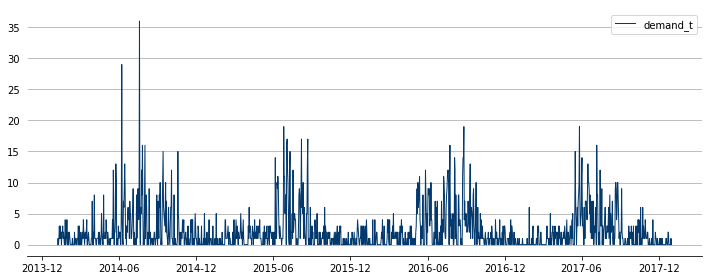

In [3]:
plot(total, 'Date', 'demand_t')

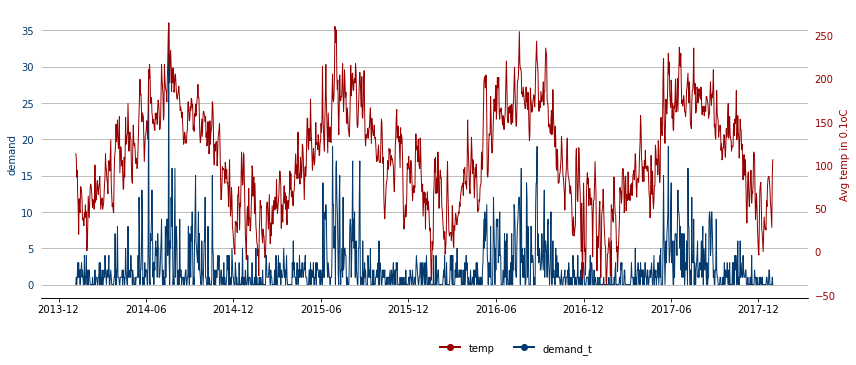

In [4]:
plot_double(total, total, 'Date', 'demand_t', 
                'Date', 'temp', 'demand', 'Avg temp in 0.1oC', 
                legend_left='', legend_right='', 
                xlabel='', title='', size=(12, 5))

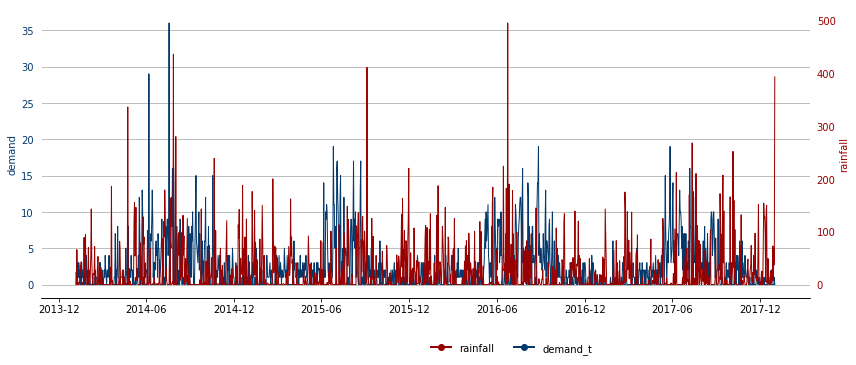

In [5]:
plot_double(total, total, 'Date', 'demand_t', 
                'Date', 'rainfall', 'demand', 'rainfall', 
                legend_left='', legend_right='', 
                xlabel='', title='', size=(12, 5))

We can clearly see a relationship between the temperature and demand as it seems that the demand increases when the temperature does. The retailers seems to sell products related to the weather, perhaps products for a barbecue. Moreover, it does seem that some seasonality exists in the demand as demand increases around the summer. 

In [6]:
total.corr()

,demand_t,temp,rainfall
demand_t,1.000000,0.515352,-0.281119
temp,0.515352,1.000000,0.037043
rainfall,-0.281119,0.037043,1.000000


As it turns out there is a clear positive relationship between the demand and the temperature. Moreover, a negative relationship seems to exist between the amount of rainfall and the demand. This further validates that the products are related to the weather conditions where sunny weather seems to be of importance. 

### Preprocessing Steps
In order to create a solid model, for each t the following features were generated:
* Temperature of t, t-7 and t-14
* Rainfall of t, t-7 and t-14
* The day of the month for t, t-7 and t-14
* The month of t, t-7 and t-14
* The week of t, t-7 and t-14
* Which day of the week of t, t-7 and t-14
* Demand of t-7 and t-14

Thus, in order to predict demand at t all features of t-7 and t-14 are taken into account together with all features of t except for the demand at t as that would lead to overfitting.  

### Model Selection
In this section an overview is given of the possible Data Science techniques that could be used for the prediction task. 

Due to having to predict integers as output in the form of time series data, the problem can be treated in three different manners:
A classification problem where the demand is treated as classes that it can predict
Methods would include Decision Trees, Random Forests and k-NN
A time series problem that would leverage information at day t from all days before
Methods would include Facebook’s Prophet or ARIMA-based approaches
A regression problem that where the demand is predicted as a float and rounded after calculating S
Methods would include Linear Regression, Lasso, Ridge, etc. 

The first approach (as we saw in the previous assignment) cannot generalize well to data not seen before as it could not predict higher or lower than the maximum and minimum demand respectively previously seen. 

The second approach is beneficial as it takes into account all previous information and leverages the demand over time to predict the demand at day t and t+1. However, these approaches are difficult to use with additional data. Moreover, at every single day the model needs to be retrained as new information is available. This normally would be of no problem as the model can then be run every day. However, as a simulation model this would decrease the computational efficiency of the model and for that reason will not be used. 

The final approach can be used if the demand has a strong relation with weather such that it can be included as additional information. It can be trained a single time and then used for predictions of a different year. For example, the model can be trained on 2014 and used for prediction on 2015. The disadvantage is that it does not fully leverage information from previous days. 

As with the previous assignment, state-of-the-art regression models are compared: CatBoost (Dorogush, Ershov, & Gulin, 2018), LightGBM (Ke et al., 2017) and XGBoost (Chen & Guestrin, 2016). Two experiments were held: one to compare the out-of-the-box performance of the models and one in which the hyper parameters of the model are fine-tuned. In order to compare the accuracy of models a 10-fold cross validation task was executed. The RMSE as defined in the assignment was used as an objective measure. Moreover, the time of training the model was also tracked. 


# Simulation Model - Moving Average

In [7]:
train = pd.read_excel('Data2014-2016.xlsx')
test = pd.read_excel('Data2017.xlsx')
train = create_feature_df(train)
test = create_feature_df(test)

In [8]:
(D_real, D_pred, D_ordered, Waste, Shortage, 
 fill_rate, error) = simulation_prediction(test, T_warm=14, m=5, z=2.1109274232754047, sim_type='moving average')

calculate_statistics(D_real, D_pred, D_ordered, Waste, 
                         Shortage, fill_rate, error, cw=100, cs=500);

Waste %: 		 31.024
Short %: 		 5.556
Avg order cost: 	 155.655
Avg fillrate: 		 0.991
RMSE (Demand): 		 3.1683892557876274
aRMSE:			 5.152451959410184


# Simulation Model - Prediction Model

**Validate and optimize Models**  
As can be seen all models have similar performance. However, LightGBM seems to be fastest and has slightly the best score. In order to further validate all models they were trained on 2014-2016 and used for the prediction of 2017 in the simulation model.

In [10]:
# model = CatBoostRegressor(logging_level='Silent')
# model = XGBRegressor()
# model = LGBMRegressor()

# for method, model in [('CatBoost', CatBoostRegressor(logging_level='Silent')),
#                       ('XGBoost', XGBRegressor()),
#                       ('LightGBM', LGBMRegressor())]:
#     result = rmse_cross_validation(model, total.iloc[:, 2:].values, total['demand_t'])
#     print('{} \t Scores: {}'.format(method, np.mean(result)))

print("Catboost\tScores: 1.9413737981444832")
print("XGBoost\t\tScores: 2.047845236670338")
print("LightGBM\tScores: 1.913695143887881")

Catboost	Scores: 1.9413737981444832
XGBoost		Scores: 2.047845236670338
LightGBM	Scores: 1.913695143887881


In [16]:
# model = CatBoostRegressor(logging_level='Silent')
# model = XGBRegressor()
# model = LGBMRegressor()

# for method, model in [('CatBoost', CatBoostRegressor(logging_level='Silent')),
#                       ('XGBoost', XGBRegressor()),
#                       ('LightGBM', LGBMRegressor())]:
#     result = rmse_cross_validation(model, total.iloc[:, 2:].values, total['demand_t'])
#     print('{} \t Scores: {}'.format(method, np.mean(result)))

print("Catboost\tScores: 1.9413737981444832")
print("XGBoost\t\tScores: 2.047845236670338")
print("LightGBM\tScores: 1.913695143887881")

Catboost	Scores: 1.9413737981444832
XGBoost		Scores: 2.047845236670338
LightGBM	Scores: 1.913695143887881


In [4]:
for method, model in [('CatBoost', CatBoostRegressor(logging_level='Silent')),
                      ('XGBoost', XGBRegressor()),
                      ('LightGBM', LGBMRegressor())]:
    print(method)
    model = train_model(train, model)

    (D_real, D_pred, D_ordered, Waste, Shortage, 
     fill_rate, error) = simulation_prediction(test, T_warm=14, m=5, z=2,sim_type='prediction')

    calculate_statistics(D_real, D_pred, D_ordered, Waste, 
                             Shortage, fill_rate, error, cw=100, cs=500);
    print()

CatBoost
Waste %: 		 13.549
Short %: 		 2.846
Avg order cost: 	 64.881
Avg fillrate: 		 0.992
RMSE (Demand): 		 1.5483283845807072
aRMSE:			 2.3898282683970162

XGBoost
Waste %: 		 12.195
Short %: 		 3.117
Avg order cost: 	 63.988
Avg fillrate: 		 0.991
RMSE (Demand): 		 1.4938953230760663
aRMSE:			 2.2271145642640255

LightGBM
Waste %: 		 14.489
Short %: 		 2.981
Avg order cost: 	 69.048
Avg fillrate: 		 0.991
RMSE (Demand): 		 1.6046056988226847
aRMSE:			 2.4228736330865432



We can clearly see that out-of-the-box XGBoost seems to have the best performance and can generalize significantly better (looking at the costs) than CatBoost and LightGBM even though LightGBM demonstrated the best performance in the previous validation experiment. Thus, it is always best to do additional experiments to validate the extent to which a model can generalize well to unseen data. 

The validation shows XGBoost to have the best performance and can generalize well to unseen data. Moreover, it is a model that is relatively fast to train such that we can optimize the hyper parameters efficiently. Below the model will be explained and additional experiments for hyper parameter optimization will be executed. 


### XGBoost

Similar to what we have seen in the previous assignment, XGBoost, also known as extreme-gradient boosting, is a method that employs boosting. Boosting is a method that uses multiple weak predictors on top of each other. Each predictor corrects the errors that were found in the previous predictor. This method is similar to bagging but employs the principle sequentially rather than using independent predictors.    

XGBoost uses Decision Trees as the sequential predictors and builts those one at a time such that each Boosted Decision Tree can learn from the previous. It then uses gradient descent to update the weights of the predictors in order to minimize the loss when adding a new prediction. Thus, gradient descent is used to update the model. LightGBM, CatBoost and XGBoost all use a similar approach and therefore (as seen in the validation steps) get similar performance. Differences between the algorithms are small and generally relate to how splits are made in the Decision Trees. 


** Parameter Optimization **

In [17]:
X = total.iloc[:, 2:].values
y = total['demand_t']

model = XGBRegressor()
space  = [Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, 10, name='min_child_weight'),
          Integer(3, 10, name='max_depth'),
          Integer(100, 1000, name='num_estimators'),
          Categorical(['gbtree', 'gblinear','dart'], name='booster')]

@use_named_args(space)
def objective(**params):
    model.set_params(**params)
    return np.mean(np.sqrt(-cross_val_score(model, X, y, scoring="mean_squared_error", cv=5, n_jobs=-1)))

model_gp = gp_minimize(objective, space, n_calls=10, random_state=0, verbose=False)
"Best score=%.4f" % model_gp.fun

Best score = 2.000


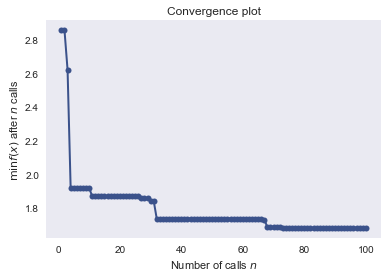

In [58]:
test = plot_convergence(model_gp);

Interestingly, even though different parameters were found, they give the same performance as the out-of-the-box approach. It turns out that XGBoost already was out-of-the-box the best approach. 

In [9]:
model = XGBRegressor(learning_rate=0.05062645559769, min_child_weight=10, max_depth=3,
                    nr_estimators=100)
model = train_model(train, model)

(D_real, D_pred, D_ordered, Waste, Shortage, 
 fill_rate, error) = simulation_prediction(test, T_warm=14, m=5, z=1.9984636778242986
,sim_type='prediction')

calculate_statistics(D_real, D_pred, D_ordered, Waste, 
                         Shortage, fill_rate, error, cw=100, cs=500);

Waste %: 		 12.409
Short %: 		 2.981
Avg order cost: 	 63.095
Avg fillrate: 		 0.993
RMSE (Demand): 		 1.4795619395702566
aRMSE:			 2.2400111729693144


# Prescriptive Analytics 


To get an indication of the optimal z value for both the moving average approach and the prediction model approach the simulation model was run for 2017 for values of z between 1 and 20. Below the results can be found for both approaches. The red cost is related to the red y-axis on the right and the blue waste (solid line) and blue shortage (dashed line) are related to the blue y-axis on the left. 

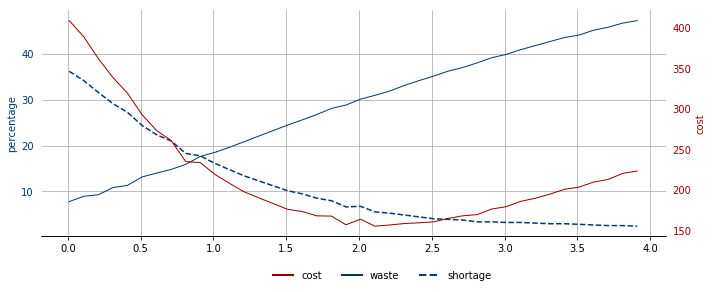

In [15]:
df = pd.DataFrame(columns=['z', 'waste', 'shortage', 'cost'])

for i in np.arange(0.1, 20, 0.1):
    (D_real, D_pred, D_ordered, Waste, Shortage, 
 fill_rate, error) = simulation_prediction(test, T_warm=14, m=5, z=i, sim_type='moving average')

    waste, short, cost = calculate_statistics(D_real, D_pred, D_ordered, Waste, 
                         Shortage, fill_rate, error, cw=100, cs=500, to_print=False)
    df.loc[len(df)] = [i, waste, short, cost]

plot_all(df)

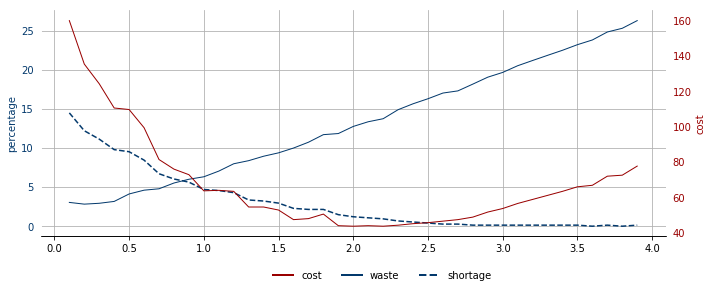

In [12]:
model = XGBRegressor(learning_rate=0.05062645559769, min_child_weight=10, max_depth=3,
                    nr_estimators=100)
model = train_model(train, model)

df = pd.DataFrame(columns=['z', 'waste', 'shortage', 'cost'])

for i in np.arange(0.1, 4, 0.1):
    (D_real, D_pred, D_ordered, Waste, Shortage, 
 fill_rate, error) = simulation_prediction(test, T_warm=0, m=5, z=i, sim_type='prediction')

    waste, short, cost = calculate_statistics(D_real, D_pred, D_ordered, Waste, 
                         Shortage, fill_rate, error, cw=100, cs=500, to_print=False)
    df.loc[len(df)] = [i, waste, short, cost]

plot_all(df)

Both approaches show a similar type of graph. The costs decrease as it finds a more optimal z value, but increases as too much is being ordered. Similarly, as more is being ordered the percentage of waste increases and the shortage decreases. 